# Workshop DL01: Deep Neural Networks*

## Agenda:
- Introduction to deep learning  
- Apply DNN to MNIST dataset and IEEE fraud dataset

For this workshop we are gonna talk about deep learning algorithms and train DNN models with 2 datasets. We will first start with an easier dataset as demonstration, namely the MNIST dataset. Then we will move on to the harder dataset, which is the IEEE fraud detection dataset, so we can also compare the performance of supervised learning and deep learning models.

## Exercises:
- Think about what features to include in your model and how they should be represented.  
- Apply DNN to house price dataset from last workshop

*We recommand running this notebook on colab, gcloud or other cloud instance to avoid over-heating you computer.

### Deep Learning Paradigm:
There is no clear cut definition of deep learning as many people tend to have different definitions, but the most popular opinion is that deep-learning could be defined as neural network with more than 2 hidden layers and later evolved into including unsupervised neural architectures. 
<img src="paradigm.png">

### Deep Learning Application:
| Neural Network | Application |
| :------------: | :---------: | 
|Standard NN|Real Estate, Online Advertising|
|Convolutional NN|Photo Tagging|
|Recurrent NN|Speech Recognition, Machine Translation|
|Unsupervised NN|Fraud Detection|

### So what is a neural network?
Recall that in the classification workshop we have introduced a GLM model called **Perceptron**. This is actually the very structural building block of neural network (NN).

| Perceptron | Activation |
|:----------:| :--------: |
|<img src="perceptron.png">|<img src="activation.png">|

Notations:
- $g$: activation function (activation function is to capture the non-linearities in the dataset) 
- $X$: input matrix 
- $w_0$: bias 
- $W$: weight matrix


A **NN** can then be viewed as a stack of multi-output perceptrons. For example, the hidden layer is a perceptron with 4 outputs and the output layer is a perceptron with 2 outputs: 
<img src="SNN.png" width="500">
Note that the subscripts indicates the number of layer, e.g. $W^{(1)}$ is the weight matrix for the first layer. 

Vectorization representation: 
$$ Z = w_0^{(1)} + X^TW^{(1)}$$
$$ Y = g(w_0^{(2)} + Z^TW^{(2)})$$
There are many conventions of representing NN, but they mean the same thing.

A **deep neural network (DNN)** is an extension of a single-layer NN with more than 2 hidden layers. For example, some DNN can have upto hundreds of layers:
<img src="DNN.png" width="500">

Note that input and output layers are not counted as the number of layers of a NN. 

Suppose we have a $l$-layer NN then the vectorization representation is: 
$$ Z^{(k)} = w_0^{(k)} + g(Z^{(k-1)})^TW^{(k)}, where \space  k = 1,2,..l-1$$
$$ Y = g(w_0^{(l)} + Z^{(l-1)T}W^{(l)})$$

Getting the matrix dimemsion correct can be quite tricky.

### Then how do we train a NN?
First we need to define a **cost function** then update the parameters ($W,w_0$) by minimising the cost. This is known as **back propagation**, whereas computing output is known as **forward propagation**. 

Considering a sample size of n, cost function is a function of predicted output ($\hat{Y^{[i]}}=f(X^{[i]},W)$) and actual output ($Y^{[i]}$): 
$$J(\hat{Y^{[i]}},W) = \frac{1}{n} \sum_{i=1}^n{L(\hat{Y^{[i]}},Y^{[i]})}$$, where $L$ could be:
- binary cross entropy loss: $Y^{[i]}\log{(\hat{Y^{[i]}})}+(1-Y^{[i]})\log{(1-\hat{Y^{[i]}})}$
- mean square loss: $(Y^{[i]}-\hat{Y^{[i]}})^2$

After we define a cost function, we need a way to update the parameters that minimise the cost. There are many ways but let's start with the most basic one, namely **gradient descent**. As the name suggests, we want to find the parameters by decreasing gradient gradually because a function decreases the fastest if one goes from a random point in the opposite direction of the gradient at that point. So we update the parameters like this:
$$new W = old W - \alpha \frac{\partial J(old W)}{\partial old W}$$
where $\alpha$ is the learning rate.

Graph Representation:

|Step 1|Step 2|
|:----:|:----:|
|<img src="step1.png">|<img src="step2.png">|

|Step 3|Step 4|
|:----:|:----:|
|<img src="step3.png">|<img src="step4.png">|


Notice that $J$ is not a direct funtion of $W$, so differentiating it with respect to $W$ is not straight forward. So we need to use Chain Rule: 
$$\frac{\partial J(\hat{Y^{[i]}},W)}{\partial W} = \frac{\partial J(\hat{Y^{[i]}},W)}{\partial \hat{Y^{[i]}}}\frac{\partial \hat{Y^{[i]}}}{\partial Z^{[i]}}\frac{\partial Z^{[i]}}{\partial W}$$


Imgages Source: ©MIT 6.S191: Introduction to Deep Learning [introtodeeplearning.com](http://introtodeeplearning.com/)

### Alternative ways of training NNs:
We have only covered one way of training NN, which is gradient descent. In practise, there are many other concerns that require better training methods. For example, **the choice of learning rate $\alpha$** have great impact on the whether we can find the true minimum. Too small the $\alpha$ converges slowly and can get stuck in local minima, whereas too big the $\alpha$ will overshoot and might not converge. We can try different values of $\alpha$ which could take a long time, or we can use **adaptive learning rate** (Momentum, RMSProp, Adam, Afagrad, Adadelta, learning rate decay etc.). 

Other than choosing learning rate, there are many popular options to improve training or fitting. Here we provide a list for you to consider:
- Train a small size of data each time: Minibatch Training, Stochastic Gradient Descent
- Normalisation of input, Batch Normalisation
- Regularization: add $l_1, l_2$ in cost funtion, dropout, early stopping, data augmentation  
- [Parallelize computation](https://www.tensorflow.org/guide/keras#multiple_gpus), use of GPU/TPU 

Now enough with the jiber jaber and let's train a DNN!

We will be using Keras and Tensorflow for all our deep learning workshops. Some of you may notice that there's a new version of tensorflow that supoorts more fancy functions, but we're using the old version as it's more stable. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras

print(tf.__version__)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


### Example 1: MNIST Data with Feed Forward Neural Networks 

Our task would be to label each image, as to which number it belong to exactly. 

For any image classification task, first, we have to understand how are image stored on devices. In this example, all images are 28$*$28 pixels, hence the input layer dimension would be 784 (28$*$28). 

For demonstration, we use a feedforward neural network with 2 hidden layers here. Of course, there are much more complicated neural architectures such as CNN's etc. 

<img src="MnistExamples.png">

#### Step 1: Import the data and Visualization

Training input data shape: (60000, 28, 28)
Training output data shape: (60000,)
Testing input data shape: (10000, 28, 28)
Testing output data shape: (10000,)


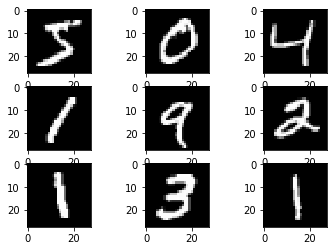

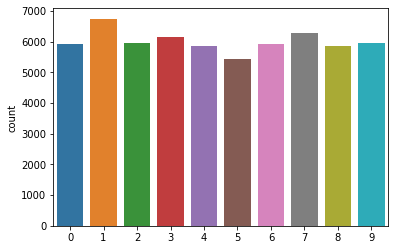

In [6]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training input data shape: {}".format(x_train.shape))
print("Training output data shape: {}".format(y_train.shape))
#This implies there exist 60,000 images with 28x28 pixels 
print("Testing input data shape: {}".format(x_test.shape))
print("Testing output data shape: {}".format(y_test.shape))
#This implies there exist 10,000 images with 28x28 pixels

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

sns.countplot(y_train)

#### Step 2: Data Preparation 

So we have 60,000 training images and 10,000 testing images with $28*28$ pixels, which we need to flatten into a single input like this:
<img src="flatten.png">


In [3]:
from keras.utils import plot_model, to_categorical 
input_vector_dimension = 28*28
num_classes = 10

# flattening input
x_train = x_train.reshape(x_train.shape[0], input_vector_dimension).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], input_vector_dimension).astype('float32') / 255
# Think: why do we divide by 255? 

# changing target output into categorical format, e.g. (0,0,1,0, ...,0) for digit 2
y_train = to_categorical(y_train, num_classes) 
y_test = to_categorical(y_test, num_classes)

print("Training input data shape after reshaping: {}".format(x_train.shape))
print("Testing input data shape after reshaping: {}".format(x_test.shape))
print("Training output data after reshaping: {}".format(y_train.shape))
print("Testing output data after reshaping: {}".format(y_test.shape))

Training input data shape after reshaping: (60000, 784)
Testing input data shape after reshaping: (10000, 784)
Training output data after reshaping: (60000, 10)
Testing output data after reshaping: (10000, 10)


#### Step 3: Neural Architecture Design
This is where we design each layer, cost funstion as well as algorithms used to update parameters (i.e. optimizers). 

##### Layers configuration: 

i.e. things we can put in `tf.keras.layers.Dense()` or `tf.keras.layers.Input()`
- **activation**: by calling the name of activation functions, e.g `activation='relu'`
- **initialization**: by calling initialization methods, e.g `bias_initializer=tf.keras.initializers.constant(2.0)`, `kernel_initializer='orthogonal'`, 
- **regularization**: by calling the regularization methods, e.g. `kernel_regularizer=tf.keras.regularizers.l1(0.01)`, `bias_regularizer=tf.keras.regularizers.l2(0.01)`, `activity_regularizer=tf.keras.regularizers.l2(0.01)`
- note: kernel = $Z_1, ...Z_n$, bias = $w_0$, activity = $g(Z_1), ...g(Z_n)$
- [explore more](https://www.tensorflow.org/api_docs/python/tf/keras/layers)

##### Model configuration:

i.e. things we can put in `tf.keras.Model.compile()`
- **optimizer**: `tf.train.AdamOptimizer`, `tf.train.RMSPropOptimizer`, or `tf.train.GradientDescentOptimizer`
- **loss**: `mse`, `categorical_crossentropy`, and `binary_crossentropy`
- **metrics**: `['mae']` for regression, `['accuracy']` for classification
- [and so on](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

There are 2 methods of creating the model, **sequential** API and **functional** API. For the sake of completeness, we show both of them here, but in practise functional API is preferrable since it supports more complex models such as:
- Multi-input models,
- Multi-output models,
- Models with shared layers (the same layer called several times),
- Models with non-sequential data flows (e.g. residual connections),
- and so on depending on your creativity.
[Here](https://www.tensorflow.org/beta/guide/keras/functional) are examples on how to use functional API for CNN, RNN.

In [4]:
# method 1: sequential model
from tensorflow.keras import layers
from keras import regularizers
from keras.models import Model

# initialize a model then add layers sequentially
model1 = tf.keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model1.add(layers.Dense(128, activation='relu'))
# Add another:
model1.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model1.add(layers.Dense(10, activation='softmax'))

# set up training
model1.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# method 2: functional model
from keras.layers import Input, Dense

# define each layer then combine 
input_layer = Input(shape=(input_vector_dimension,))
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
output_layer = Dense(10, activation='softmax')(hidden_layer_2)
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()
# set up training 
model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [6]:
# using l1 in functional API 
from keras.layers import Input, Dense

# define each layer then combine 
input_layer = Input(shape=(input_vector_dimension,))
hidden_layer_1 = Dense(128, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
output_layer = Dense(10, activation='softmax')(hidden_layer_2)
model_l1 = Model(inputs=input_layer, outputs=output_layer)

model_l1.summary()
# set up training 
model_l1.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
# using drop out in funtional API
from keras.layers import Dropout

input_layer = Input(shape=(input_vector_dimension,))
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_1 = Dropout(0.4)(hidden_layer_1)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
output_layer = Dense(10, activation='softmax')(hidden_layer_2)
model_dr = Model(inputs=input_layer, outputs=output_layer)

model_dr.summary()
# set up training 
model_dr.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


#### Step 4: Train the Model 
This is where we design on how to train our model, such as mini-batch training. 

Training configuration:
i.e. things we can put in `model.fit()`
- **epochs**: number of loops over the entire data
- **batch_size**: data size we use for each iteration to update parameters
- **validation_split**: percentage of data we use to monitor the model performance by some metric after each epoch
- [and so on](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [8]:
# training models
args = dict(x = x_train, y = y_train,
            batch_size=64,
            epochs=20,
            validation_split=0.5,
            verbose=2) # set verbose equal to 1 here to view the progress bar

history_base = model.fit(**args)
print('base model fitted')

history_l1 = model_l1.fit(**args)
print('l1 model fitted')

history_dr = model_dr.fit(**args)
print('dropout model fitted')

Instructions for updating:
Use tf.cast instead.
Train on 30000 samples, validate on 30000 samples
Epoch 1/20
 - 2s - loss: 0.5987 - acc: 0.8178 - val_loss: 0.1949 - val_acc: 0.9449
Epoch 2/20
 - 2s - loss: 0.2035 - acc: 0.9458 - val_loss: 0.1859 - val_acc: 0.9521
Epoch 3/20
 - 2s - loss: 0.1896 - acc: 0.9554 - val_loss: 0.2760 - val_acc: 0.9454
Epoch 4/20
 - 2s - loss: 0.1762 - acc: 0.9600 - val_loss: 0.2266 - val_acc: 0.9555
Epoch 5/20
 - 2s - loss: 0.1677 - acc: 0.9653 - val_loss: 0.2765 - val_acc: 0.9513
Epoch 6/20
 - 2s - loss: 0.1698 - acc: 0.9669 - val_loss: 0.3675 - val_acc: 0.9469
Epoch 7/20
 - 2s - loss: 0.1677 - acc: 0.9689 - val_loss: 0.3373 - val_acc: 0.9479
Epoch 8/20
 - 2s - loss: 0.1617 - acc: 0.9716 - val_loss: 0.3149 - val_acc: 0.9578
Epoch 9/20
 - 2s - loss: 0.1710 - acc: 0.9743 - val_loss: 0.3076 - val_acc: 0.9615
Epoch 10/20
 - 2s - loss: 0.1675 - acc: 0.9740 - val_loss: 0.3109 - val_acc: 0.9602
Epoch 11/20
 - 2s - loss: 0.1710 - acc: 0.9747 - val_loss: 0.3243 - val

#### Step 5: Monitor Performance 

In [10]:
test_scores = model.evaluate(x_test, y_test)
print('Base Test loss:', test_scores[0])
print('Base Test accuracy:', test_scores[1])

test_scores = model_l1.evaluate(x_test, y_test)
print('l1 Test loss:', test_scores[0])
print('l1 Test accuracy:', test_scores[1])

test_scores = model_dr.evaluate(x_test, y_test)
print('Dropout Test loss:', test_scores[0])
print('Dropout Test accuracy:', test_scores[1])

10000/10000 [==============================] - 0s 35us/step
Base Test loss: 0.5149250918225655
Base Test accuracy: 0.9565
10000/10000 [==============================] - 0s 36us/step
l1 Test loss: 0.572751255118847
l1 Test accuracy: 0.8778
10000/10000 [==============================] - 0s 36us/step
Dropout Test loss: 0.26011443918464067
Dropout Test accuracy: 0.9565


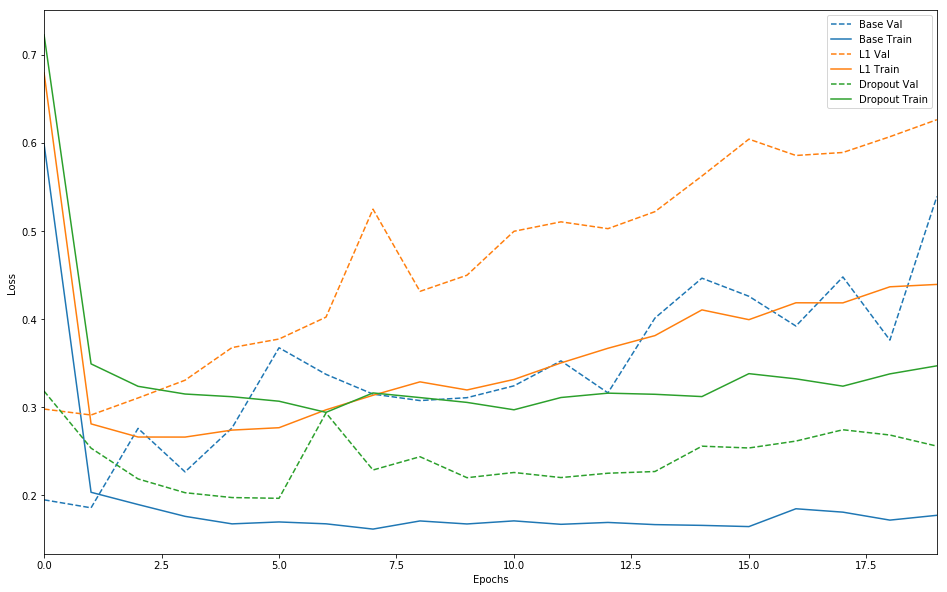

In [9]:
def plot_history(histories, key='loss'): # set key to 'loss' or 'acc' to view metrics
    plt.figure(figsize=(16,10))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
    
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])

plot_history([('base',history_base),
              ('l1', history_l1),
              ('dropout',history_dr)])

Lastly, save the trained model so you can load it later.

In [11]:
from keras.models import load_model, save_model
model.save('my_model.h5')
model = tf.keras.models.load_model('my_model.h5')

/home/leung0222/anaconda3/lib/python3.5/site-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Example 2: IEEE Data 

In [12]:
# read csv file into a dataframe
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')

In [13]:
from sklearn.model_selection import train_test_split
train_size = int(0.8*X_train.shape[0])
test_size = X_train.shape[0]-train_size
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, train_size=train_size, test_size=test_size, random_state=4)

In [14]:
from sklearn import preprocessing
# Normalize Training Data 
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_norm = std_scale.transform(X_train)
# Normalize Testing Data by using mean and SD of training set
X_test_norm = std_scale.transform(X_test)

In [17]:
pd.DataFrame(X_train_norm).head()

,0,1,2,3,4,5,6,7,8,9,...,421,422,423,424,425,426,427,428,429,430
0,0.547507,0.643952,0.569898,1.866597,-0.423994,0.920831,1.004828,0.034225,-0.841841,-0.755327,...,-0.546744,-0.285865,-0.505615,-0.510319,-0.083003,-0.087361,-0.089169,-0.090304,-0.092353,-0.384832
1,-0.154450,-0.982659,-1.620863,-1.113573,4.607196,-1.086020,-1.055983,-1.029108,-0.841841,-0.755327,...,1.485039,-0.285865,3.333161,2.344598,-0.083003,-0.087361,-0.089169,-0.090304,-0.092353,2.277084
2,0.547507,0.643952,0.569898,1.866597,-0.423994,0.920831,1.004828,1.097559,0.190372,0.529474,...,-0.546744,-0.285865,-0.505615,-0.510319,-0.083003,-0.087361,-0.089169,-0.090304,-0.092353,-0.384832
3,0.547507,0.643952,0.569898,-1.113573,-0.423994,0.920831,1.004828,0.034225,-0.841841,-0.755327,...,-0.546744,-0.285865,-0.505615,-0.510319,-0.083003,-0.087361,-0.089169,-0.090304,-0.092353,-0.384832
4,0.547507,-0.982659,0.569898,-0.175371,-0.423994,-1.086020,-1.055983,-1.029108,0.190372,1.814276,...,-0.546744,-0.285865,-0.505615,-0.510319,-0.083003,-0.087361,-0.089169,-0.090304,-0.092353,-0.384832


In [21]:
# definin the model
input_layer = Input(shape=(X_train.shape[1],))

hidden_layer_1 = Dense(256, activation='relu',activity_regularizer=regularizers.l1(10e-3))(input_layer)
hidden_layer_2 = Dense(128, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(128, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(64, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(32, activation='relu')(hidden_layer_4)

output_layer = Dense(1, activation='sigmoid')(hidden_layer_5)

nn_model = Model(inputs=input_layer, outputs=output_layer)
nn_model.summary()

nn_model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(10e-5),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 431)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               110592    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total para

In [22]:
# training model 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# This callback will stop the training when there is no improvement in
# the validation loss for 2 consecutive epochs.
history = nn_model.fit(X_train_norm, Y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.1, 
                    verbose=2,
                    callbacks=[callback])

Train on 425188 samples, validate on 47244 samples
Epoch 1/20
 - 48s - loss: 0.7823 - acc: 0.9650 - val_loss: 0.2388 - val_acc: 0.9650
Epoch 2/20
 - 47s - loss: 0.2708 - acc: 0.9650 - val_loss: 0.2500 - val_acc: 0.9650
Epoch 3/20
 - 47s - loss: 0.2478 - acc: 0.9651 - val_loss: 0.1895 - val_acc: 0.9650
Epoch 4/20
 - 46s - loss: 0.2378 - acc: 0.9651 - val_loss: 0.2515 - val_acc: 0.9650
Epoch 5/20
 - 45s - loss: 0.2237 - acc: 0.9650 - val_loss: 0.1974 - val_acc: 0.9650
Epoch 6/20
 - 46s - loss: 0.1940 - acc: 0.9651 - val_loss: 0.1868 - val_acc: 0.9650
Epoch 7/20
 - 46s - loss: 0.1953 - acc: 0.9651 - val_loss: 0.1905 - val_acc: 0.9650
Epoch 8/20
 - 45s - loss: 0.1806 - acc: 0.9651 - val_loss: 0.1770 - val_acc: 0.9650
Epoch 9/20
 - 46s - loss: 0.1743 - acc: 0.9651 - val_loss: 0.1840 - val_acc: 0.9650
Epoch 10/20
 - 46s - loss: 0.1787 - acc: 0.9651 - val_loss: 0.1756 - val_acc: 0.9650
Epoch 11/20
 - 46s - loss: 0.1628 - acc: 0.9651 - val_loss: 0.1607 - val_acc: 0.9650
Epoch 12/20
 - 46s - lo

In [23]:
# test error
test_scores = nn_model.evaluate(X_test_norm, Y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


from sklearn.metrics import classification_report, confusion_matrix
Y_predict = nn_model.predict(X_test_norm)
Y_predict.dtype
Y_predict = np.argmax(Y_predict, axis=1)

matrix = confusion_matrix(Y_test.values, Y_predict)
report = classification_report(Y_test.values, Y_predict,digits = 6)
print(matrix);print(report)

Test loss: 0.15543428982432997
Test accuracy: 0.964828800762665
[[113954      0]
 [  4154      0]]
             precision    recall  f1-score   support

          0   0.964829  1.000000  0.982100    113954
          1   0.000000  0.000000  0.000000      4154

avg / total   0.930895  0.964829  0.947558    118108



/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Similar problem as before, that the algorothm tends to overlook infrequent class and classify everything to positive to maximise accuracy. Usual solution to imbalance dataset is to assign more weights to the infrequent class, but for this dataset it doesn't work either as the following shows ([Why?](http://203.170.84.89/~idawis33/DataScienceLab/publication/IJCNN15.wang.final.pdf?fbclid=IwAR3_PqZsqLpP9psST0KugZOACrrfpugw6oVHY5_Uc_m50v4ei4zrXE4ddU4)). More advanced unsupervised models might provide a solution to it as we move on to later workshops.  

In [24]:
# definin the model
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer_1 = Dense(256, activation='relu',activity_regularizer=regularizers.l1(10e-3))(input_layer)
hidden_layer_2 = Dense(128, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(128, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(64, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(32, activation='relu')(hidden_layer_4)
output_layer = Dense(1, activation='sigmoid')(hidden_layer_5)
w_model = Model(inputs=input_layer, outputs=output_layer)

w_model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(10e-3),
              metrics=['accuracy'])


class_weight = {0: 1., 1: 28.} # class "0" is roughly 28 times more represented than calss "1"
# training model with customised weights
history_w = w_model.fit(X_train_norm, Y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.1, 
                    verbose=2,
                    callbacks=[callback],
                    class_weight=class_weight)

Train on 425188 samples, validate on 47244 samples
Epoch 1/20
 - 48s - loss: 2.3468 - acc: 0.7945 - val_loss: 1.4800 - val_acc: 0.0350
Epoch 2/20
 - 47s - loss: 1.4744 - acc: 0.3942 - val_loss: 1.4173 - val_acc: 0.9650
Epoch 3/20
 - 46s - loss: 1.4440 - acc: 0.3914 - val_loss: 1.5577 - val_acc: 0.9650
Epoch 4/20
 - 46s - loss: 1.4548 - acc: 0.3835 - val_loss: 1.4295 - val_acc: 0.0350
Epoch 5/20
 - 48s - loss: 1.4183 - acc: 0.4301 - val_loss: 1.4367 - val_acc: 0.0350
Epoch 6/20
 - 47s - loss: 1.3979 - acc: 0.4099 - val_loss: 1.4289 - val_acc: 0.9650


In [25]:
# test error
test_scores = w_model.evaluate(X_test_norm, Y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])


from sklearn.metrics import classification_report, confusion_matrix
Y_predict = nn_model.predict(X_test_norm)
Y_predict = np.argmax(Y_predict, axis=1)

matrix = confusion_matrix(Y_test.values, Y_predict)
report = classification_report(Y_test.values, Y_predict,digits = 6)
print(matrix);print(report)

Test loss: 0.7418078060041462
Test accuracy: 0.964828800762665
[[113954      0]
 [  4154      0]]
             precision    recall  f1-score   support

          0   0.964829  1.000000  0.982100    113954
          1   0.000000  0.000000  0.000000      4154

avg / total   0.930895  0.964829  0.947558    118108



/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


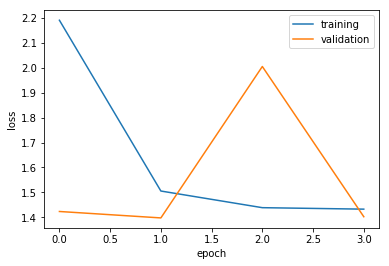

In [70]:
plt.plot(history_w.history['loss'])
plt.plot(history_w.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [ ]:
from keras.models import load_model, save_model
nn_model.save('nn_model.h5') #save_format='h5'
nn_model = tf.keras.models.load_model('nn_model.h5')